In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math

-----------

# Mission 1 - Data discovery and cleaning

The purpose of this first part is to discover the data we were handled and clean them

## Tables loading and primary key identification

In [2]:
# We get global knowledge from the table
customers = pd.read_csv('customers.csv')
customers.shape

(8623, 3)

In [3]:
# Taking a look at the table
customers.head(5)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
# We make sure the client_id is a primary key for relation customers
len(customers['client_id'].unique())

8623

In [5]:
# We get to know the second table
products = pd.read_csv('products.csv')
products.shape

(3287, 3)

In [6]:
# Taking a look at the table sample
products.head(5)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [131]:
products.loc[(products['categ'] != 0) & (products['categ'] != 1) & (products['categ'] != 2)]

,id_prod,price,categ
10,2_228,225.17,2
38,2_100,72.11,2
64,2_89,107.99,2
73,2_225,157.99,2
79,2_187,157.99,2
...,...,...,...
3188,2_99,84.99,2
3196,2_238,93.92,2
3267,2_101,63.99,2
3271,2_123,147.99,2


In [7]:
# id_prod is a primary key for the products relation
len(products['id_prod'].unique())

3287

In [8]:
# Loading the last table
transactions = pd.read_csv('transactions.csv')
transactions.shape

(337016, 4)

In [9]:
# Looking at a sample
transactions.head(5)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [10]:
# Several calculations do not allow to determine a primary key. Duplicates are probably in the data

In [11]:
transactions_duplicated = transactions[transactions.duplicated()]
transactions_duplicated

,id_prod,date,session_id,client_id
34387,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_0
54813,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
57261,T_0,test_2021-03-01 02:30:02.237439,s_0,ct_1
58802,T_0,test_2021-03-01 02:30:02.237429,s_0,ct_0
60170,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_0
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


In [12]:
transactions_duplicated['id_prod'].unique()

array(['T_0'], dtype=object)

In [13]:
# T_0 is a legitimate id_prod
products[products['id_prod'] == 'T_0']

,id_prod,price,categ
731,T_0,-1.0,0


In [14]:
# It appears only dates including test_ as a prefix are concerned with duplicates
# Moreover those dates are not valid dates

transactions[transactions['date'] == 'test_2021-03-01 02:30:02.237421']

,id_prod,date,session_id,client_id
227121,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
293107,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1


In [15]:
# It appears that 200 data are defined as tests and therefore as non valid for our study
transactions['test'] = [ True if ('test' in date) else False for date in transactions['date']]
transactions[transactions['test']].shape

(200, 5)

Ainsi on trouve 200 entrees de test dans les transactions et il semble qu'elles soient toutes liees au produit T_0.

In [16]:
test_id_prod_mask = transactions['id_prod'] == 'T_0'
test_date_mask2 = transactions['date'].str.contains('test_.*', regex=True)
transactions.loc[test_id_prod_mask & test_date_mask2]

,id_prod,date,session_id,client_id,test
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,True
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,True
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,True
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,True
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,True
...,...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,True
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,True
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,True
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1,True


## Cleaning data

In [17]:
# We drop ROWs (axis=0)
customers.dropna(axis=0, how='any').shape[0]

8623

In [18]:
products.dropna(axis=0, how='any').shape[0]

3287

In [19]:
transactions.dropna(axis=0, how='any').shape[0]

337016

Ici on voit qu'il n'y a pas de valeurs manquantes dans les tables products, customers ou transactions

In [20]:
print(customers['sex'].unique())

['f' 'm']


In [21]:
products_prices_lst = products['price'].unique()
products_prices_lst.sort()
products_prices_lst

array([ -1.  ,   0.62,   0.66, ..., 247.22, 254.44, 300.  ])

Les prix n'ont pas de valeurs aberrantes en dehors de la valeur -1 associee au produit T_0 dont le nom ne semble pas correspondre a la nomenclature attendue pour les produits.

In [22]:
neg_price_mask = products['price'] < 0
products.loc[neg_price_mask]

,id_prod,price,categ
731,T_0,-1.0,0


In [23]:
prod_id_mask = products['id_prod'].str.contains('\d_\d+', regex=True)
products.loc[prod_id_mask].shape[0]

3286

Les noms des produits repondent tous a la nomenclature 'chiffre unique, underscore, un ou plusieurs chiffre', le produit T_0 etant l'unique valeur ne suivant pas cette nomenclature avec un prix negatif. Ce dernier est de plus lie aux transactions de test avec des dates non conforme. On peut donc le retirer de notre analyse.

In [24]:
id_mask = customers['client_id'].str.contains('^c(?!_\d+)', regex=True)
customers.loc[id_mask]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


De la meme facon on identifie deux clients dont la nomenclature ne verifie pas 'c, underscore, serie de chiffre' et qui sont eux aussi associes aux donnees de transactions de test.
On verifie cela sur les donnees de transactions.

In [25]:
test_client_id_mask = transactions['client_id'].str.contains('^c(?!_\d+)', regex=True)
transactions.loc[test_client_id_mask]

,id_prod,date,session_id,client_id,test
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,True
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,True
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,True
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,True
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,True
...,...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,True
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,True
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,True
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1,True


In [26]:
dates = transactions.loc[:,'date'].tolist()
dates.sort()
print(dates[0], dates[-1])

2021-03-01 00:01:07.843138 test_2021-03-01 02:30:02.237450


Rien d'anormal sur les dates, qui sont repertoriees entre 2021 et 2022 bien que situees dans le futur au niveau des annees.

In [27]:
# All session_id match the naming convention
session_id_mask = transactions['session_id'].str.contains('s_\d+', regex=True)
transactions.loc[session_id_mask].shape[0]

337016

En resume on elimine alors les elements suivants:
- lignes de customers avec les valeurs 'ct_X'
- lignes de products avec la valeur 'T_0'
- lignes de transactions avec un des valeur precedentes ou des dates non conformes commencant par 'test_'

In [28]:
products = products.loc[prod_id_mask]
correct_id_mask = customers['client_id'].str.contains('c_\d+', regex=True)
customers = customers.loc[correct_id_mask]
test_mask = transactions['id_prod'] != 'T_0'
transactions = transactions.loc[test_mask]

In [29]:
# Checking original dataframes have been updated
print(products.shape[0], customers.shape[0], transactions.shape[0])

3286 8621 336816


-----

# Mission 2: Data analysis

Vous devrez y utiliser au moins :

- des indicateurs de tendance centrale et de dispersion
- une analyse de concentration, via une courbe de Lorenz et un indice de Gini
- des représentations graphiques, dont au moins un histogramme, une représentation avec des "boites à moustaches", et - une représentation de série temporelle (c’est à dire un graphique dont l’axe des abscisses représente des dates)
- des analyses bivariées


## Customers analysis

First we focus on the customers data

In [30]:
male_msk = customers['sex'] == 'm', 'sex'
female_msk = customers['sex'] == 'f', 'sex'
nb_males = customers.loc[male_msk].count()
nb_females = customers.loc[female_msk].count()
print(nb_males, nb_females, nb_males+nb_females)

4131 4490 8621


In [31]:
sex_freq = customers['sex'].value_counts(normalize=True)
sex_freq

f    0.520821
m    0.479179
Name: sex, dtype: float64

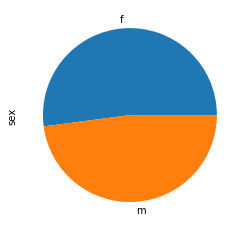

In [32]:
sex_freq.plot(kind='pie')

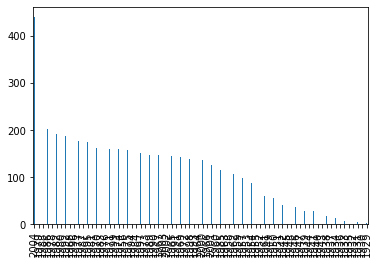

In [33]:
birth_freq = customers['birth'].value_counts()
birth_freq.plot(kind='bar', width=0.1)

In [34]:
customers['age'] = 2019 - customers['birth']
customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,52
1,c_7839,f,1975,44
2,c_1699,f,1984,35
3,c_5961,f,1962,57
4,c_5320,m,1943,76


In [43]:
# Sturges rule to estimate optimal class number
kc = 1+ math.log(customers.shape[0], 2)
kc

14.07363951028323

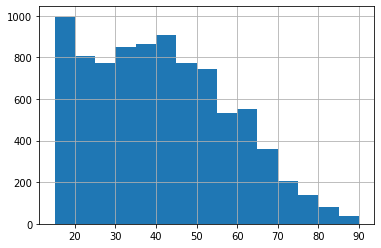

In [36]:
age_freq = customers['age'].hist(density=False, bins = 15)

In [113]:
print(f'le pic d age est de {customers["age"].mode().array[0]} ans, \n\
la valeur mediane est a {customers["age"].median()} ans, \n\
et la moyenne d age est de {customers["age"].mean()} annees\n\
avec un ecart type empirique de {customers["age"].std(ddof=0)}\n\
skew: {customers["age"].skew()}\n\
kurtosis: {customers["age"].kurtosis()}\
')

le pic d age est de 15 ans, 
la valeur mediane est a 40.0 ans, 
et la moyenne d age est de 40.724393921818816 annees
avec un ecart type empirique de 16.91697679632548
skew: 0.360813881775354
kurtosis: 0.360813881775354


## Products analysis

In [37]:
# Sturges rule 
kp = 1 + math.log(products.shape[0],2)
kp

12.682116764950074

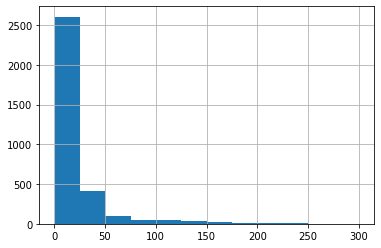

In [38]:
products['price'].hist(density=False, bins=12)

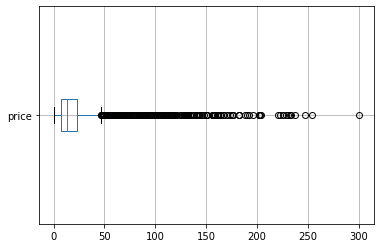

In [121]:
products.boxplot(column='price', vert=False)

In [115]:
def central_measures(series):
    print(f'le pic de prix est de {series.mode().array[0]},\n\
la valeur mediane des prix est a {series.median()},\n\
et la moyenne de prix est de {series.mean()}\n\
avec un ecart type empirique de {series.std(ddof=0)}\n\
skew: {series.skew()}\n\
kurtosis: {series.kurtosis()}\n\
')

In [116]:
central_measures(products['price'])

le pic de prix est de 4.99,
la valeur mediane des prix est a 13.075,
et la moyenne de prix est de 21.86359707851491
avec un ecart type empirique de 29.845243318099023
skew: 3.79840808478482
kurtosis: 17.94701369603558



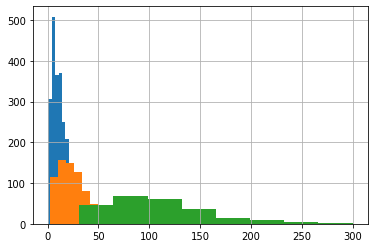

In [117]:
categ_lst = products['categ'].unique().tolist()
categ_lst.sort()
categ_map = {}
for cat in categ_lst:
    msk = products['categ'] == cat, 'price'
    categ_map.update({cat: products.loc[msk]})
for cat, series in categ_map.items():
    ktab = 1 + math.log(len(series.array),2)
    ktab = math.floor(ktab)
    series.hist(density=False, bins=ktab)

In [118]:
for cat, series in categ_map.items():
    print(f'Pour les produits de categorie {cat}')
    central_measures(series)
    print('\n\n')


Pour les produits de categorie 0
le pic de prix est de 4.99,
la valeur mediane des prix est a 10.32,
et la moyenne de prix est de 11.732794627383015
avec un ecart type empirique de 7.5641157561691745
skew: 0.8387209779498822
kurtosis: 0.3324478551097827




Pour les produits de categorie 1
le pic de prix est de 22.99,
la valeur mediane des prix est a 22.99,
et la moyenne de prix est de 25.531420838971584
avec un ecart type empirique de 15.414721633623802
skew: 0.8120109621070365
kurtosis: 0.2993533794236898




Pour les produits de categorie 2
le pic de prix est de 50.99,
la valeur mediane des prix est a 101.99,
et la moyenne de prix est de 108.35468619246862
avec un ecart type empirique de 49.45763740520641
skew: 0.9310209579538592
kurtosis: 0.808968484300689






In [39]:
categ_freq = products['categ'].value_counts(normalize=True)
categ_freq

0    0.702374
1    0.224893
2    0.072733
Name: categ, dtype: float64

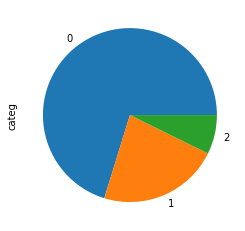

In [40]:
categ_freq.plot(kind='pie')

## Transactions analysis

In [41]:
# Sturges rule 
kt = 1 + math.log(transactions.shape[0],2)
kt

19.36160114779474

In [122]:
transactions.head()

,id_prod,date,session_id,client_id,test
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,False
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,False
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,False
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,False
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,False


- Merge les tables en un dataframe
- Transcrire les dates en mois heures autres
- Calculer CA par exemple